# DDSP Timbre Transfer Demo 
#### written by Louis Liu, spring 2024


In this notebook we are going to load a pretrained DDSP autoencoder trained on a 15-minute violin dataset to do timbre transfer!

In [2]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf
import sounddevice as sd
from my_utils import *
import librosa
from load_model import load_model

# Load the model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model(yaml_name='config.yaml', device=device)

Loading model...
number of parameters: 2231466


# Load voice and extract features

In [ ]:
fs = 16000  # Sample rate
seconds = 10 # Duration of recording
fname = 'sing.wav'

print(f'start recording...')
sing = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
print(f'recording ends')
sf.write(fname, sing, fs)
Audio(fname)

In [5]:
# extract clean pitch
wavname = 'ddsp_singing.wav'
# wavname = 'sing.wav'
x, fs = sf.read(wavname)
if fs != 16000:
    x = librosa.resample(x, orig_sr=fs, target_sr=16000)
    fs = 16000
pitch = torch.from_numpy(extract_pitch(signal=x, fmin=50, fmax=500, model='full', device=device))

# shift the pitch
pitch = 2 * pitch

# going through reverb
x = torch.from_numpy(x).unsqueeze(0).to(device).float()
with torch.no_grad():
    x = model.reverb(x)
x = x.squeeze().cpu().numpy()

# extract reverbed loudness
loudness = torch.from_numpy(extract_energy(signal=x))
Audio(x, rate=fs)

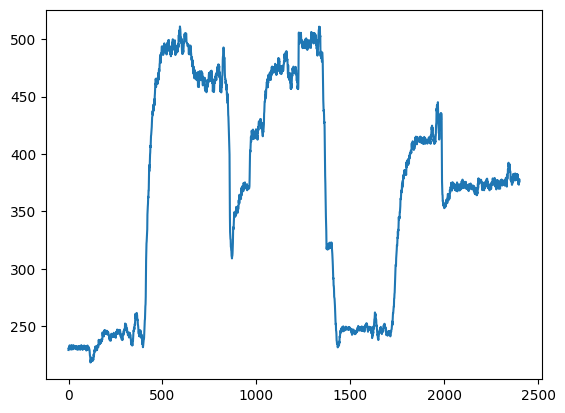

In [6]:
plt.plot(pitch)

# Timbre Transfer

In [7]:
f0 = pitch.to(device).float()[None, None, :]
l = loudness.to(device).float()[None, None, :]

# run through the model
model.eval()
with torch.no_grad():
    music = model(f0, l)
Audio(music.squeeze().cpu(), rate=fs)